In [ ]:
import re
import os

# https://github.com/microsoft/vscode-jupyter/issues/10718
os.environ["HF_TOKEN"] = re.search(
    r'HUGGINGFACE_TOKEN=([^\n]+)',
    open('/home/oleg/.bashrc').read()
).groups()[0]

In [ ]:
from datasets import load_dataset, Audio
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

from src.speaker_diarization import SpeakerDiarizationWrapper, get_speech_mask
from src.audioset_utils import pad_or_trim_to_len

In [ ]:
sova = (
    load_dataset('datasets/sova_128k', data_files='00000-of-00608.parquet', split='train')
    .cast_column('audio', Audio(decode=True, sampling_rate=16_000))
).shuffle(0)

In [ ]:
yodas = (
    load_dataset('datasets/yodas_ru000_128k_filtered5', data_files='00000-of-00079.parquet', split='train')
    .cast_column('audio', Audio(decode=True, sampling_rate=16_000))
).shuffle(0)

In [30]:
sova_audios = [s['audio']['array'] for s in sova.take(200)]
yodas_audios = [s['audio']['array'] for s in yodas.take(200)]

In [31]:
sova_order = np.argsort([len(w) for w in sova_audios])
yodas_order = np.argsort([len(w) for w in yodas_audios])

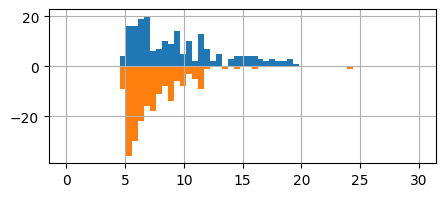

In [32]:
plt.figure(figsize=(5, 2))
plt.hist([len(w) / 16_000 for w in sova_audios], bins=np.linspace(0, 30, num=60))
plt.hist([len(w) / 16_000 for w in yodas_audios], bins=np.linspace(0, 30, num=60), weights=-np.ones(len(yodas_audios)))
plt.grid()
plt.show()

In [ ]:
speaker_diarization = SpeakerDiarizationWrapper(
    segmentation_batch_size=256,
    embedding_batch_size=128,
    device='cuda',
)

In [34]:
def get_is_speech_for_multiple_waveforms(waveforms: list[np.ndarray]):
    is_speech = []
    for waveform in tqdm(waveforms):
        segments = speaker_diarization.predict_on_long_audio(
            waveform, sampling_rate=16_000
        ).segments
        speech_mask = get_speech_mask(segments, tick_len=0.01, duration=len(waveform) / 16_000)
        speech_mask = pad_or_trim_to_len(speech_mask, 100 * 30)
        is_speech.append(speech_mask)
    return np.array(is_speech)

is_speech_sova = get_is_speech_for_multiple_waveforms(sova_audios)
is_speech_yodas = get_is_speech_for_multiple_waveforms(yodas_audios)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

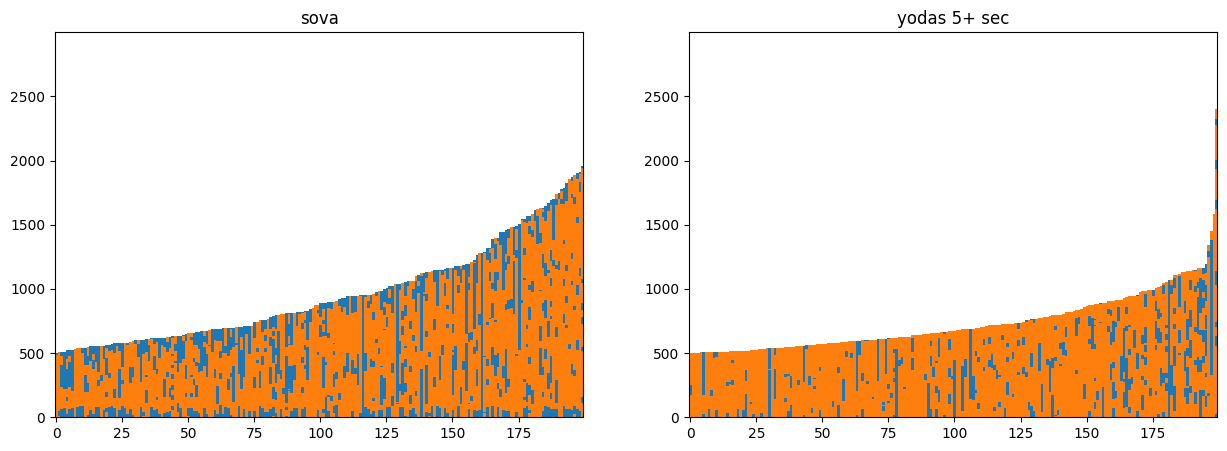

In [35]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=2)

axs[0].imshow(is_speech_sova[sova_order].T, aspect='auto', cmap='tab10', interpolation='none', vmin=0, vmax=9, origin='lower')
axs[0].set_title('sova')

axs[1].imshow(is_speech_yodas[yodas_order].T, aspect='auto', cmap='tab10', interpolation='none', vmin=0, vmax=9, origin='lower')
axs[1].set_title('yodas 5+ sec')

plt.show()